In [22]:
from bqplot import pyplot as plt
import bqplot as bq
import ipywidgets as widgets
from src.imports import read_eye_data
from src.analysis import get_sac_onsets_offsets
from src.analysis import predict_possible_saccades
from src.imports import append_list_as_row
from src.imports import check_results_file
import math
import matplotlib
import numpy as np
from numpy import matlib

# init some values
iTrial   = 0
curr_sac = 0
this_trial_save_flag = False

# check if csv file is present in the /results folder. if not, make it
check_results_file()

# get the data
x_matrix,y_matrix  = read_eye_data()
ntrials, trialtime = np.shape(x_matrix)

# predict possible saccades based on old weights
total_predictions  = predict_possible_saccades(x_matrix,y_matrix,sampfreq=1000,min_sacc_dur=12,min_sacc_dist = 50)

# get the predicted saccade onsets and offsets
onsets, offsets    = get_sac_onsets_offsets(total_predictions)
this_trial_n_sacs  = len(onsets[iTrial][0])

# set textbox that shows current trial
current_trial_text = widgets.Text(value="{}".format(iTrial + 1),description='Current trial:',
                                  disabled=False,style = {'description_width': 'initial'},layout=widgets.Layout(flex='1 1 30%', width='auto'))


def next_trial(obj):
    global iTrial
    iTrial += 1
    new_trial()
    update()

    
def previous_trial(obj):
    global iTrial
    iTrial -= 1
    new_trial()
    update()
    
def next_sac(obj):
    global iTrial, this_trial_n_sac, curr_sac
    if curr_sac < this_trial_n_sacs-1:
        curr_sac += 1
    if curr_sac is not None:
        patch_curr_sac.x = patch_x_coords[curr_sac]
        patch_curr_sac.y = patch_y_coords[curr_sac]
        intsel.selected  = [patch_x_coords[curr_sac][0]-10,patch_x_coords[curr_sac][2]+10]
        zoom_selector.selected = []
        
    update()
    update_trace_zoom()

def previous_sac(obj):
    global iTrial, curr_sac
    if curr_sac > 0:
        curr_sac -= 1
    if curr_sac is not None:
        patch_curr_sac.x = patch_x_coords[curr_sac]
        patch_curr_sac.y = patch_y_coords[curr_sac]
        intsel.selected  = [patch_x_coords[curr_sac][0]-10,patch_x_coords[curr_sac][2]+10]
        zoom_selector.selected = []
        
    update()
    update_trace_zoom()
    
    update()

def del_sac(obj):
    global this_trial_onsets, this_trial_offsets, this_trial_n_sacs
    if this_trial_onsets.size > 0:
        this_trial_onsets   = np.delete(this_trial_onsets,curr_sac)
        this_trial_offsets  = np.delete(this_trial_offsets,curr_sac)

        this_trial_n_sacs   = this_trial_n_sacs - 1
        intsel.selected = [patch_x_coords[curr_sac][0]-10,patch_x_coords[curr_sac][2]+10]
    
        update_patches()
    else:
        update_patches()
    
    
def update_patches():
    global patch_x_coords, patch_y_coords
    patch_x_coords     = []
    patch_y_coords     = []

    
    for sac in range(len(this_trial_onsets)):
        l1= [this_trial_onsets[sac],this_trial_onsets[sac],this_trial_offsets[sac],this_trial_offsets[sac]]
        patch_x_coords.append(l1)
        patch_y_coords.append([-1,1,1,-1])
    


    patch.x = patch_x_coords
    patch.y = patch_y_coords

    
    if curr_sac is not None:
        if curr_sac == len(this_trial_onsets):
            patch_curr_sac.x = patch_x_coords[curr_sac]
            patch_curr_sac.y = patch_y_coords[curr_sac]
        else:
            patch_curr_sac.x = patch_x_coords[curr_sac]
            patch_curr_sac.y = patch_y_coords[curr_sac]
    else:
            patch_curr_sac.x = []
            patch_curr_sac.y = []   
    

def new_trial():
    global patch_x_coords, patch_y_coords, this_trial_onsets, this_trial_offsets, this_trial_n_sacs, this_trial_save_flag, curr_sac
    this_trial_save_flag = False
    # update the patches for this trial
    curr_sac = None
    this_trial_onsets        = onsets[iTrial][0]
    this_trial_offsets       = offsets[iTrial][0]
    
    
    # just for now:
    this_trial_onsets        = np.array([])
    this_trial_offsets       = np.array([])
    this_trial_n_sacs        = len(onsets[iTrial][0])  


    patch_x_coords     = []
    patch_y_coords     = []
    
    
    for sac in range(len(this_trial_onsets)):
        l1= [this_trial_onsets[sac],this_trial_onsets[sac],this_trial_offsets[sac],this_trial_offsets[sac]]
        patch_x_coords.append(l1)
        patch_y_coords.append([-1,1,1,-1])
        
    
    patch.x = patch_x_coords
    patch.y = patch_y_coords
    
    if curr_sac is not None:
        patch_curr_sac.x = patch_x_coords[curr_sac]
        patch_curr_sac.y = patch_y_coords[curr_sac]
        intsel.selected  = [patch_x_coords[curr_sac][0]-10,patch_x_coords[curr_sac][2]+10]
        zoom_selector.selected = []
   
    
def update(*ignore):
    global iTrial, this_trial_onsets, this_trial_offsets
    # update the lare line plots
    Line_eye_x.y =  x_matrix[iTrial,:] - np.mean(x_matrix[ iTrial, :])
    Line_eye_y.y =  y_matrix[iTrial,:] - np.mean(y_matrix[ iTrial, :])
    current_trial_text.value =  "{}".format(iTrial + 1) # this gives the current trial that we are working on
    
    # update the current saccade patch
    if curr_sac is not None:
        patch_curr_sac.x        = patch_x_coords[curr_sac]
        patch_curr_sac.y        = patch_y_coords[curr_sac]
        
        new_y = [np.min([Line_zoom_y.y,Line_zoom_x.y])-0.2,np.max([Line_zoom_y.y,Line_zoom_x.y])+0.2,np.max([Line_zoom_y.y,Line_zoom_x.y])+0.2,np.min([Line_zoom_y.y,Line_zoom_x.y])-0.2]
        patch_curr_sac_zoomed.x = patch_x_coords[curr_sac]
        patch_curr_sac_zoomed.y = new_y
        
  
    
    
def update_trace_zoom(*ignore):
    global iTrial, this_trial_n_sacs, xmin, xmax
    if intsel.selected is not None and len(intsel.selected) == 2:
        xmin, xmax = intsel.selected
        xmin = int(np.round(xmin))
        xmax = int(np.round(xmax))

        # update the plots
        Line_zoom_x.y  = x_matrix[iTrial, xmin : xmax] - np.mean(x_matrix[iTrial, xmin : xmax])
        Line_zoom_y.y  = y_matrix[iTrial, xmin : xmax] - np.mean(y_matrix[iTrial, xmin : xmax])
        Line_zoom_x.x  = np.linspace(xmin,xmax,xmax-xmin)
        Line_zoom_y.x  = np.linspace(xmin,xmax,xmax-xmin)
        x_sc_zoom.min  = xmin
        x_sc_zoom.max  = xmax
        


def edit_sac(*ignore):
    global  this_trial_onsets, this_trial_offsets, curr_sac
    if curr_sac is not None:
        if zoom_selector.selected is not None and len(zoom_selector.selected) == 2:
            new_on, new_off = zoom_selector.selected

            this_trial_onsets[curr_sac]  = round(new_on)
            this_trial_offsets[curr_sac] = round(new_off)

            update_patches()
   
        
        
def save_trial(*ignore):
    global this_trial_save_flag, vec
    # create again a binary representation of the events
    vec = np.zeros((1000,1))
    for sac in range(len(this_trial_onsets)):
        vec[int(this_trial_onsets[sac]):int(this_trial_offsets[sac])] = np.ones(( int(this_trial_offsets[sac]-this_trial_onsets[sac]),1 ))
    
    if not this_trial_save_flag:
        append_list_as_row('./results/binary_labels.csv',vec)
        this_trial_save_flag = True

    
def save_new_sac(*ignore):
    global this_trial_onsets,this_trial_offsets, curr_sac
    if curr_sac is not None:
        if new_selector.selected is not None and len(new_selector.selected) == 2:
            new_on, new_off = new_selector.selected

            this_trial_onsets  = np.append(this_trial_onsets,round(new_on))
            this_trial_offsets = np.append(this_trial_offsets,round(new_off))
        
    
            Mode.value = 'Edit saccade'

        
            
    else:
        curr_sac = 0
        if new_selector.selected is not None and len(new_selector.selected) == 2:
            new_on, new_off = new_selector.selected

            this_trial_onsets  =  np.append(this_trial_onsets,round(new_on))
            this_trial_offsets = np.append(this_trial_offsets,round(new_off)) 
            Mode.value = 'Edit saccade'

    
    update_patches()
    
        
def empty(*ignore):
    pass

def select_curr_sac(*ignore):
    global this_trial_onsets,this_trial_offsets, curr_sac, center, index_min, onset_diffs, offset_diffs
    if intsel.selected is not None and len(intsel.selected) == 2:
        try:
            minwin, maxwin = intsel.selected
            minwin = int(np.round(minwin))
            maxwin = int(np.round(maxwin))
            center = np.mean([minwin,maxwin])
            onset_diffs  = np.abs(this_trial_onsets  - center)
            offset_diffs = np.abs(this_trial_offsets - center)
            curr_sac = np.argmin(onset_diffs + offset_diffs )
        except:
            curr_sac = None
        update()


    
def toggle_fun(*ignore):
    if Mode.value == 'Create new saccade':
        zoom_fig.interaction = new_selector
    if Mode.value == 'Edit saccade':
        zoom_fig.interaction = zoom_selector
    update_patches()
        
    

##################################################
#### define buttons and assign their callback ####
##################################################

# trial buttons
next_trial_button = widgets.Button(description='Next trial',disabled=False,button_style='') 
next_trial_button.on_click(next_trial)
previous_trial_button = widgets.Button(description='Previous trial',disabled=False,button_style='') 
previous_trial_button.on_click(previous_trial)

# saccade buttons
next_saccade_button = widgets.Button(description='Next saccade',disabled=False,button_style='') 
next_saccade_button.on_click(next_sac)
previous_saccade_button = widgets.Button(description='Previous saccade',disabled=False,button_style='') 
previous_saccade_button.on_click(previous_sac)

# edit saccades buttons
delete_curr_sac = widgets.Button(description='Delete sac',disabled=False,button_style='danger') 
delete_curr_sac.on_click(del_sac)
delete_curr_sac.on_click(update)


save_trial_button = widgets.Button(description='Save trial',disabled=False,button_style='') 
save_trial_button.on_click(save_trial) 


save_new_sac_button = widgets.Button(description='Save new sac',disabled=False,button_style='') 
save_new_sac_button.on_click(save_new_sac) 



Mode = widgets.ToggleButtons(options=['Edit saccade','Create new saccade'],description='Saccade Edit Mode:',disabled=False,description_allow_html=True,style = {'description_width': 'initial'})

Mode.observe(toggle_fun,'value')

###################################
### PLOTTING STUFF HAPPENS HERE ###
###################################
animation_time = 300 # this is animation speed

# define axes for different plots
y_ax        = bq.Axis(label="x/y position (dva)",scale=bq.LinearScale(),orientation="vertical")
x_ax        = bq.Axis(label="time (ms)",scale=bq.LinearScale(min=1,max=trialtime),orientation="horizontal")
x_sc_zoom   = bq.LinearScale(min=0)
y_sc_zoom   = bq.LinearScale()
x_zoom_ax   = bq.Axis(label="time (ms)",scale=x_sc_zoom,orientation="horizontal")
y_zoom_ax   = bq.Axis(label="prediction",scale=y_sc_zoom,orientation="vertical")
Line_eye_x  = plt.plot(x=np.arange(trialtime),scales={'x':bq.LinearScale(min=1,max=trialtime),'y':bq.LinearScale()},colors = ['fuchsia'])
Line_eye_y  = plt.plot(x=np.arange(trialtime),scales={'x':bq.LinearScale(min=1,max=trialtime),'y':bq.LinearScale()},colors = ['green'])
Line_zoom_x = plt.plot(scales={'x':x_sc_zoom,'y':y_sc_zoom},colors = ['fuchsia'])
Line_zoom_y = plt.plot(scales={'x':x_sc_zoom,'y':y_sc_zoom},colors = ['green'])


##################################
### Selectors are defined here ###
##################################

intsel = bq.interacts.FastIntervalSelector(scale=bq.LinearScale(min=1,max=trialtime),marks=[Line_eye_x],color='red')
intsel.observe(update_trace_zoom,names=['selected']) # updates the zoomed in eye traces
intsel.observe(select_curr_sac,names=['selected']) # updates which one is considered the current saccade

# selector within the zoomed view that selects the saccade onsets and offset
zoom_selector = bq.interacts.BrushIntervalSelector(scale=x_sc_zoom,marks=[Line_zoom_x],color='pink')
zoom_selector.observe(edit_sac,names=['selected'])
zoom_selector.observe(update)
new_selector  = bq.interacts.BrushIntervalSelector(scale=x_sc_zoom,marks=[Line_zoom_x],color='green')
    


################################
#### Boxes are defined here ####
################################

# patch plot that highlights all detected/suggested the saccades
patch = plt.plot(scales={'x':bq.LinearScale(min=1,max=trialtime),'y':bq.LinearScale()},close_path=True,
                 stroke_width=0,fill='inside',opacities=[0.25],colors=['gray'])

# patch plot that highlights the current saccade
patch_curr_sac = plt.plot(scales={'x':bq.LinearScale(min=1,max=trialtime),'y':bq.LinearScale()},close_path=True, stroke_width=0,fill='inside',opacities=[0.5])

# patch of current saccade in the zoomed in plot
patch_curr_sac_zoomed = plt.plot(scales={'x':x_sc_zoom,'y':y_sc_zoom },close_path=True, stroke_width=0,fill='inside',opacities=[0.2])

# define boxes
trial_navigation_box = widgets.HBox(children= [previous_trial_button,next_trial_button,previous_saccade_button,
                                    next_saccade_button,current_trial_text,save_trial_button],
                                    layout=widgets.Layout(margin='10px 0px 10px 0px',border=' solit 1px',height="50px",
                                    flex_flow='row',width='100%',display='center'))

mode_box    = widgets.HBox(children=[Mode],layout=widgets.Layout(display='flex',flex_flow='row',align_items='center',width='70%',justify_content='space-around'))
empty_box70 = widgets.HBox(children=[],layout=widgets.Layout(display='flex',flex_flow='row',align_items='center',width='70%'))
empty_box30 = widgets.HBox(children=[],layout=widgets.Layout(display='flex',flex_flow='row',align_items='center',width='30%'))

modify_sac_box = widgets.Box(children=[delete_curr_sac,save_new_sac_button],layout=widgets.Layout(display='flex',flex_flow='row',align_items='center',width='70%',justify_content='center'))


# make eyetrace and zoom box
# first box on top with eye traces left and zoomed traces right
eyetrace_fig = bq.Figure(animation_duration=animation_time,layout=widgets.Layout(flex='1 1 30%', width='auto'),axes=[x_ax,y_ax],
    marks=[Line_eye_x,Line_eye_y,patch,patch_curr_sac],fig_margin=dict(top=25,bottom=50,left=50,right=25),interaction=intsel)

zoom_fig = bq.Figure(animation_duration=animation_time,layout=widgets.Layout(flex='1 1 0%', width='auto'),axes=[x_zoom_ax,y_zoom_ax],
    marks=[Line_zoom_x,Line_zoom_y,patch_curr_sac_zoomed],fig_margin=dict(top=25,bottom=50,left=25,right=25),interaction=zoom_selector)

box_layout = widgets.Layout(animation_duration=animation_time,display='flex',flex_flow='row',align_items='stretch',width='100%')
eyetrace_and_zoom_box = widgets.Box(children=[eyetrace_fig, zoom_fig], layout=box_layout)


# define rows
PSO_row     = widgets.HBox(children=[mode_box],layout=widgets.Layout(display='flex',flex_flow='row',align_items='center',width='100%',justify_content='space-around'))
saccade_row = widgets.HBox(children=[mode_box],layout=widgets.Layout(display='flex',flex_flow='row',align_items='center',width='100%',justify_content='space-around'))
modify_sac_row   = widgets.Box(children=[modify_sac_box],layout=widgets.Layout(display='flex',flex_flow='row',align_items='center',width='100%',justify_content='space-around'))

# build app layout
app = widgets.VBox(children=[
                               PSO_row,
                             modify_sac_row,
                             eyetrace_and_zoom_box,
                            trial_navigation_box],
                   layout=widgets.Layout(border="solid 2px gray",width="1200px"))
new_trial()
update()
app




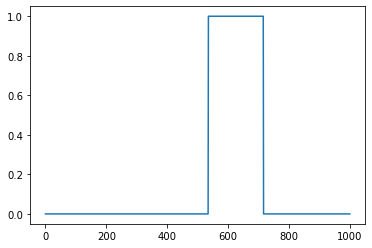

In [26]:
import matplotlib.pyplot as matplot
matplot.plot(vec)